# English - Alice in wonderland

## Data preparation

In [24]:
from importlib import reload

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/pavlem/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [36]:
import preprocessor
preprocessor = reload(preprocessor)


pp = preprocessor.Preprocessor("data/original/alice_in_wonderland.txt", "eng", False)
cleaned_corpus = pp.process()
pp.split(cleaned_corpus)

[later editions continued as follows When the sands are all dry, he is gay as a lark, And will talk in contemptuous tones of the Shark, But, when the tide rises and sharks are around, His voice has a timid and tremulous sound.].
[later editions continued as follows The Panther took pie-crust, and gravy, and meat, While the Owl had the dish as its share of the treat.
Number of unique characters: 35
Number of characters: 367
dict_keys(['[', 'l', 'a', 't', 'e', 'r', ' ', 'd', 'i', 'o', 'n', 's', 'c', 'u', 'f', 'w', 'W', 'h', 'y', ',', 'g', 'k', 'A', 'm', 'p', 'S', 'B', 'H', 'v', '.', ']', 'T', 'P', '-', 'O'])


## Subword segmentation

In [2]:
import sentpiece
sentpiece = reload(sentpiece)

# Character level train vocabular size = 68
# Character level test vocabular size = 68


NUM_CHARS = 2500
TRAIN_DATA_PATH = "data/processed/eng_test.txt"
MODEL_NAME = "eng_model_lrg_base"
TYPE = "_train"

In [41]:
sentpiece.train_model(TRAIN_DATA_PATH, MODEL_NAME + TYPE, NUM_CHARS)

sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: data/processed/eng_test.txt
  input_format: 
  model_prefix: eng_model_lrg_base_test
  model_type: BPE
  vocab_size: 2500
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
}
normalizer_spec {
  name: nmt_nfkc
  add_dummy_prefix: 1
  remove_extra_whit

In [42]:
!mv $MODEL_NAME* spm_models/

In [43]:
SEG_DATA_FILE = "eng_lrg_base_test.txt"


sentpiece.segmentation(TRAIN_DATA_PATH, MODEL_NAME + TYPE, SEG_DATA_FILE)

## Train LM

In [47]:
TRAIN_SEG_DATA_PATH = "data/segmented/eng_lrg_base_train.txt"
TEST_SEG_DATA_PATH = "data/segmented/eng_lrg_base_test.txt"
NUM_LAYERS = 60
CLASS = 2400
BPTT = 3


!bash train_script.sh $TRAIN_SEG_DATA_PATH $TEST_SEG_DATA_PATH $NUM_LAYERS $CLASS $BPTT

rm: cannot remove 'rnnlm/models/model': No such file or directory
rm: cannot remove 'rnnlm/models/model.output.txt': No such file or directory
debug mode: 2
train file: data/segmented/eng_lrg_base_train.txt
valid file: data/segmented/eng_lrg_base_test.txt
class size: 2400
Hidden layer size: 60
BPTT: 3
Rand seed: 1
rnnlm file: model
Starting training using file data/segmented/eng_lrg_base_train.txt
Vocab size: 2224
Words in train file: 29551
Iter:   0	Alpha: 0.100000	   TRAIN entropy: 8.6827    Words/sec: 2747.9   VALID entropy: 7.8984
Iter:   1	Alpha: 0.100000	   TRAIN entropy: 7.9714    Words/sec: 2827.0   VALID entropy: 7.4885
Iter:   2	Alpha: 0.100000	   TRAIN entropy: 7.5295    Words/sec: 2906.3   VALID entropy: 7.3258
Iter:   3	Alpha: 0.100000	   TRAIN entropy: 7.2084    Words/sec: 2841.0   VALID entropy: 7.2263
Iter:   4	Alpha: 0.100000	   TRAIN entropy: 6.9551    Words/sec: 3138.2   VALID entropy: 7.1319
Iter:   5	Alpha: 0.100000	   TRAIN entropy: 6.7439    Words/sec: 3090.6   V

In [45]:
MODEL_OUTPUT = MODEL_NAME + ".output.txt"

!mv model $MODEL_NAME
!mv model.output.txt $MODEL_OUTPUT

!mv $MODEL_NAME $MODEL_OUTPUT rnnlm_models/

## Data generation

In [3]:
GEN_DATA_PATH = f"data/generated/{MODEL_NAME}/"
MODEL_PATH = f"./rnnlm_models/{MODEL_NAME}"

!bash gen_script.sh $GEN_DATA_PATH $MODEL_PATH

In [26]:
# Decoding generated texts

for i in range(1, 8):
    size = 10**i
    sentpiece.desegmentation(f"data/generated/eng_model_lrg_ft/{size}.txt", MODEL_NAME + TYPE)

## Out-of-vocabulary results

In [32]:
import oov
oov_module = reload(oov)

In [33]:
# Initiate OOV object

comparer = oov_module.OOV()

Baseline OOV rate
Number of unseen words: 379.0
Total number of test words: 5415.0
OOV rate: 7.0%


In [34]:
oov_rates = comparer.check_oov()

for key, values in sorted(oov_rates.items()):
    print(f"{key}: {round(values[-1][1] * 100, 2)}%")

eng_model_chr_base: 4.95%
eng_model_chr_ft: 4.71%
eng_model_lrg_base: 5.3%
eng_model_lrg_ft: 5.13%
eng_model_sml_base: 4.73%
eng_model_sml_ft: 4.71%


No handles with labels found to put in legend.


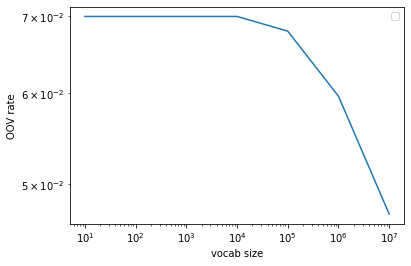

In [35]:
comparer.plot_oov_rates({value[0]: value[1] for value in oov_rates["eng_model_chr_ft"]})

No handles with labels found to put in legend.


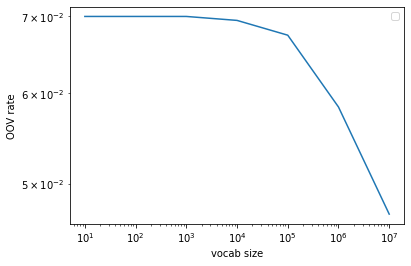

In [36]:
comparer.plot_oov_rates({value[0]: value[1] for value in oov_rates["eng_model_sml_ft"]})

No handles with labels found to put in legend.


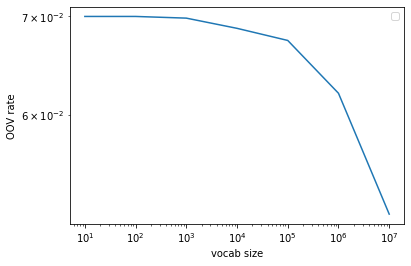

In [37]:
comparer.plot_oov_rates({value[0]: value[1] for value in oov_rates["eng_model_lrg_ft"]})

# Analysis

## Inspection of 100.txts

For fine-tuned character level:
`I Hatce'd SOMEy-can just bent-or,' wenter.'. Phear diender under.. `We cake something you was!. Th

For fine-tuned small level:
as larke quabling to said then treasnyed,' it half said to the door outcen, from once or taiced it. As quite scearst?' neal withow and at she stoo

For fine-tuned large level:
voice, before she hadme trouble puppyven its head. Alice waited in a great grunted fire on the firstched getting usu and howling high.. `They did you know up to this day,' with the March Turtle: she had al chill, with one of paw of the youth, which got the back of the distance, and said, `Speak be invit something will you, will you" have at the right? grow gave, could,' said Alice: `aslled! shallen him

### Observation


## OOV comparison

It can be seen similar trends for each level. With closer look, for smaller granularities (character and small level), visible decreases start after 10^4 text length, while in case of large level a noticeable decrease can be seen after 10^3 text length. In a production, we would use small level model, since oov-rates between it and character level models are similar, but hidden size is higher with character level, thus, we might have overfitting to some degree. Also, with higher granularity words correctness and coherence of the text increase.